# 2.5d Effnet PreTrained
[Original Link](https://www.kaggle.com/code/leventelippenszky/train-2-5d-pretrained-effnet-b0-ink-classifier)

In [3]:
import os
import gc
import numpy as np
import pandas as pd
from PIL import Image
from typing import List, Tuple
from celluloid import Camera
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import roc_auc_score
from scipy.ndimage.morphology import binary_erosion, binary_dilation

import torch
from torch import nn
from torch import Tensor
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from celluloid import Camera
import wandb
from random import random
import sys
# sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")
import timm

C:\Users\gamer\AppData\Local\Temp\ipykernel_20520\2417847575.py:12: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation
C:\Users\gamer\AppData\Local\Temp\ipykernel_20520\2417847575.py:12: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_dilation


In [4]:
# WANDB_API_KEY = '99dd38e74a56ac74fc1a83c261ff6e7d5d453fc6'
WANDB_API_KEY = 'local-a2cc501204f722abe273d32f382f7b7438873ad7'
# wandb.login(key=WANDB_API_KEY)
wandb.login(host='http://192.168.0.225:8080', key=WANDB_API_KEY)

wandb: Currently logged in as: groot. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for 192.168.0.225 to your netrc file: C:\Users\gamer/.netrc


True

In [5]:
DATA_DIR = "../data"
TRAIN_DIR = "../data/train"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

NUM_SLICES = 65
IMAGE_SHAPE = 8181, 6330
LOG_TABLE = True
DEBUG = False

config = {"model_name": "efficientnet_b0",
          "subvolume_size": 30,
          "z_start": 27,
          "z_dim": 10,
          "batch_size": 32,
          "train_rounds": 3,  # Epochs?
          "train_steps": 5000,
          "threshold": 0.6,
          "seed": 1337}

EXPERIMENT_NAME = f"{config['model_name']}-subv_{config['subvolume_size']}-zstrt_{config['z_start']}-zdim_{config['z_dim']}-bs_{config['batch_size']}-round_{config['train_rounds']}-step_{config['train_steps']}-thr_{config['threshold']}"

cuda


In [6]:
# Test WandB Server
lr = 0.01
wandb.init(
    project="basic-intro", name=f"testLocalServer2",
    config={
        "learning_rate": lr,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 5,
    })
offset = random() / 5

# for i in np.arange(0.1, 0.5, 0.1):
#     wandb.log({'accuracy':i, 'epoch': 5})
for epoch in range(2, 5):
    acc = 1 - 2 ** -epoch - random() / epoch - offset
    loss = 2 ** -epoch + random() / epoch + offset
    print(f"epoch={epoch}, accuracy={acc}, loss={loss}")
    wandb.log({"accuracy": acc, "loss": loss})
wandb.finish()

epoch=2, accuracy=0.6129318292008988, loss=0.7577772133250296
epoch=3, accuracy=0.5628473488894459, loss=0.15137585385440194
epoch=4, accuracy=0.7622474172144167, loss=0.2010339490936284


accuracy,▃▁█
loss,█▁▂
accuracy,0.76225
loss,0.20103


In [7]:
def set_seed(seed):
    """
    Sets the seed of the entire notebook for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
set_seed(config["seed"])

## Utils

In [8]:
def load_png(fragment_id: str, png_name: str) -> np.ndarray:
    fragment_dir = os.path.join(TRAIN_DIR, fragment_id)
    path = os.path.join(fragment_dir, f"{png_name}.png")
    image = Image.open(path)
    return np.array(image)
    
    
def show_array(array: np.ndarray, name: str, ax, off=True):
    ax.imshow(array, cmap="gray")
    if off:
        ax.axis("off")
    ax.set_title(f"{name}, shape: {array.shape}")
     
    
def show_pngs(mask: np.ndarray, inklabels: np.ndarray, ir: np.ndarray):
    plt.style.use("default")
    plt.rcParams["figure.dpi"] = 100    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 12))
    axs.flatten()
    show_array(mask, "mask", axs[0])
    show_array(inklabels, "inklabels", axs[1])
    show_array(ir, "ir", axs[2])
        

# TODO refactor a version that just retuns the image to show intead of plotting it?
def show_rect_on_inklabels(rect: dict, inklabels: np.ndarray):
    plt.style.use("default")
    fig, ax = plt.subplots()
    show_array(inklabels, "inklabels", ax, off=False)
    patch = Rectangle(xy=(rect["x"], rect["y"]), width=rect["width"], height=rect["height"], linewidth=2, edgecolor="red", facecolor="none")
    ax.add_patch(patch)
    plt.show()
    

def load_volume(fragment_id: str, z_start: int, z_dim: int) -> np.ndarray:
    volume_dir = os.path.join(TRAIN_DIR, fragment_id, "surface_volume")
    print(f"Volume directory: {volume_dir}")
    volume = []

    for i in range(z_start, z_start + z_dim):
        slice_path = os.path.join(volume_dir, f"{i:02d}.tif")
        slice_png = Image.open(slice_path)
        # normalize pixel intesity values into [0,1]
        slice_array = np.array(slice_png, dtype=np.float32) / 65535.0
        volume.append(slice_array)
    return np.stack(volume, axis=0)


class AverageCalc:  # Similar to 2-5d `AverageMeter` method
    """
    Calculates and stores the average and current value.
    Used to update the loss.
    """
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, value, size):
        self.value = value
        self.sum += value * size
        self.count += size
        self.avg = self.sum/self.count
        
        
class DummyLogger:  # An empty logger for when debugging. else uses below method.
    def log(self, message):
        pass
    
    def finish(self):
        pass
    
    
def create_logger(config: dict):
    logger = wandb.init(project="Vesuvius", name=EXPERIMENT_NAME, config=config)
    return logger

Volume directory: ../data/train\1\surface_volume


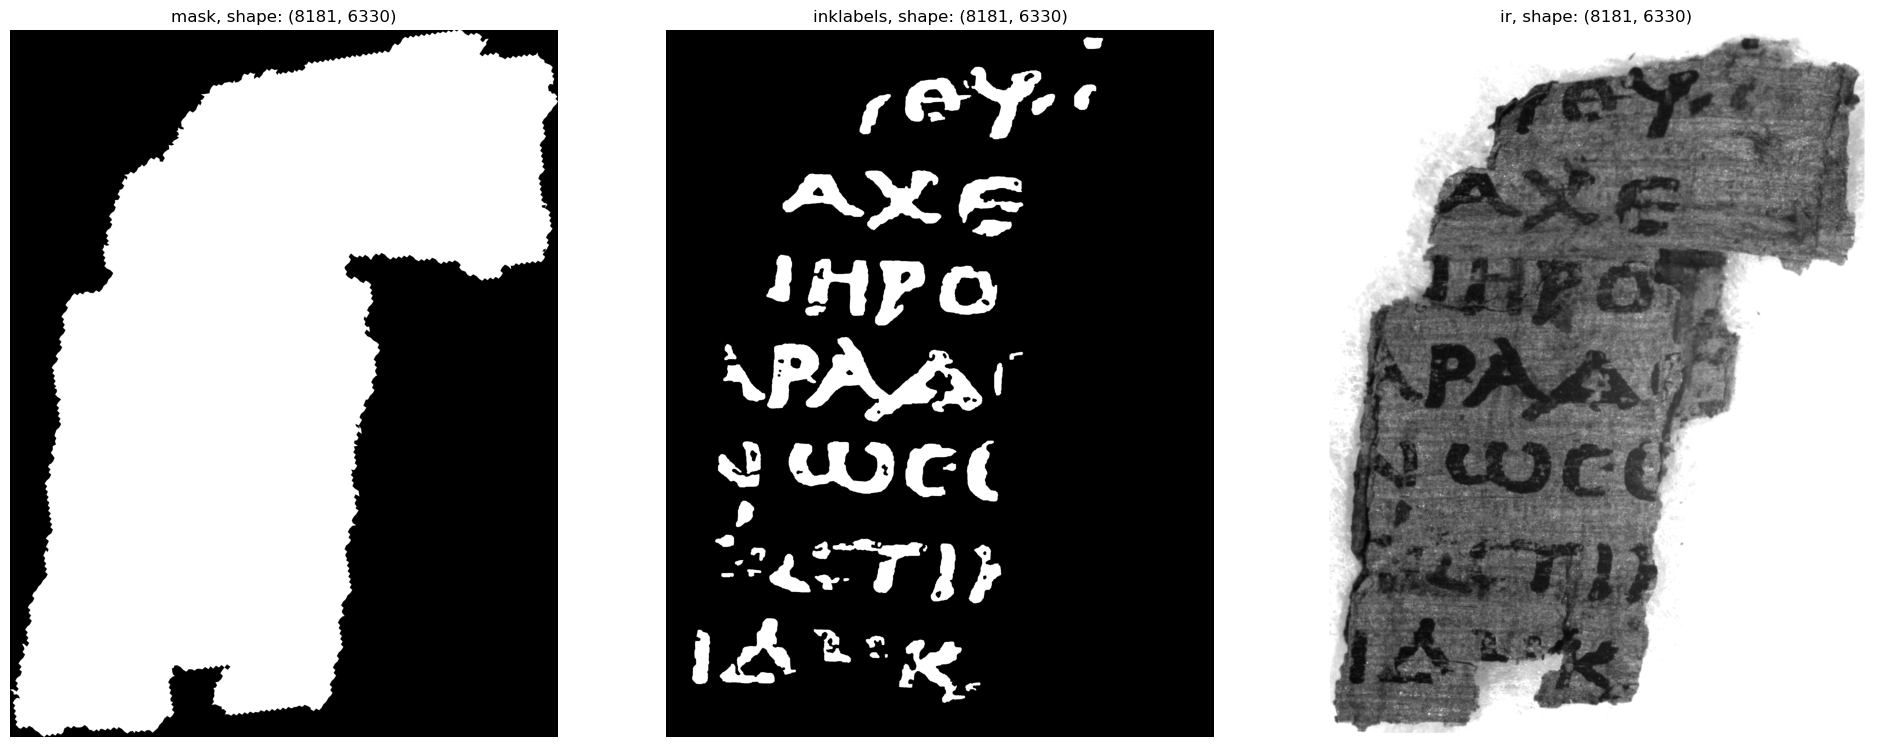

In [9]:
mask = load_png(fragment_id="1", png_name="mask")
inklabels = load_png(fragment_id="1", png_name="inklabels")
ir = load_png(fragment_id="1", png_name="ir")

volume = load_volume(fragment_id="1", z_start=config["z_start"], z_dim=config["z_dim"])
show_pngs(mask, inklabels, ir)
del ir
gc.collect();

## Training validation split with Rect

Rect. Point to start at. Then specify width and height.
Where top left is (0, 0)

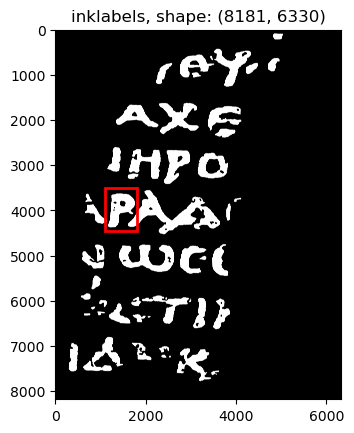

In [19]:
# Sets the validation split for the fragment.
rect2 = {"x": 1100, "y": 3500, "width": 700, "height": 950}
show_rect_on_inklabels(rect2, inklabels)

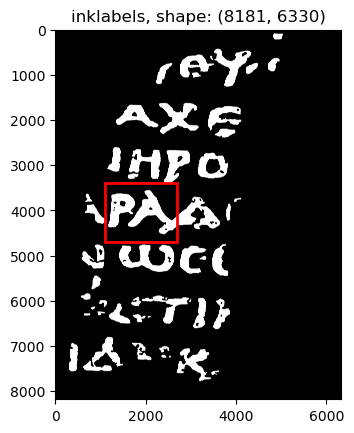

In [10]:
# Sets the validation split for the fragment.
rect = {"x": 1100, "y": 3400, "width": 1600, "height": 1300}
show_rect_on_inklabels(rect, inklabels)

In [20]:
def get_train_val_masks(mask: np.ndarray, rect: dict, subvolume_size: int) -> Tuple[np.ndarray]:
    # erode mask so that subvolumes will be fully within the mask
    eroded_mask = binary_erosion(mask, structure=np.ones((subvolume_size+10, subvolume_size+10)))
    # binary mask of the rectangle
    rect_mask = np.zeros((mask.shape), dtype=np.uint8)
    rect_mask[rect["y"] : rect["y"] + rect["height"], rect["x"] : rect["x"] + rect["width"]] = 1
    # validation set contains pixels inside the rectangle
    val_mask = eroded_mask * rect_mask
    # dilate rectangle mask so that training subvolumes will have no overlap with rectangle
    dilated_rect_mask = binary_dilation(rect_mask, structure=np.ones((subvolume_size, subvolume_size)))
    train_mask = eroded_mask * (1 - dilated_rect_mask) 
    return train_mask, val_mask

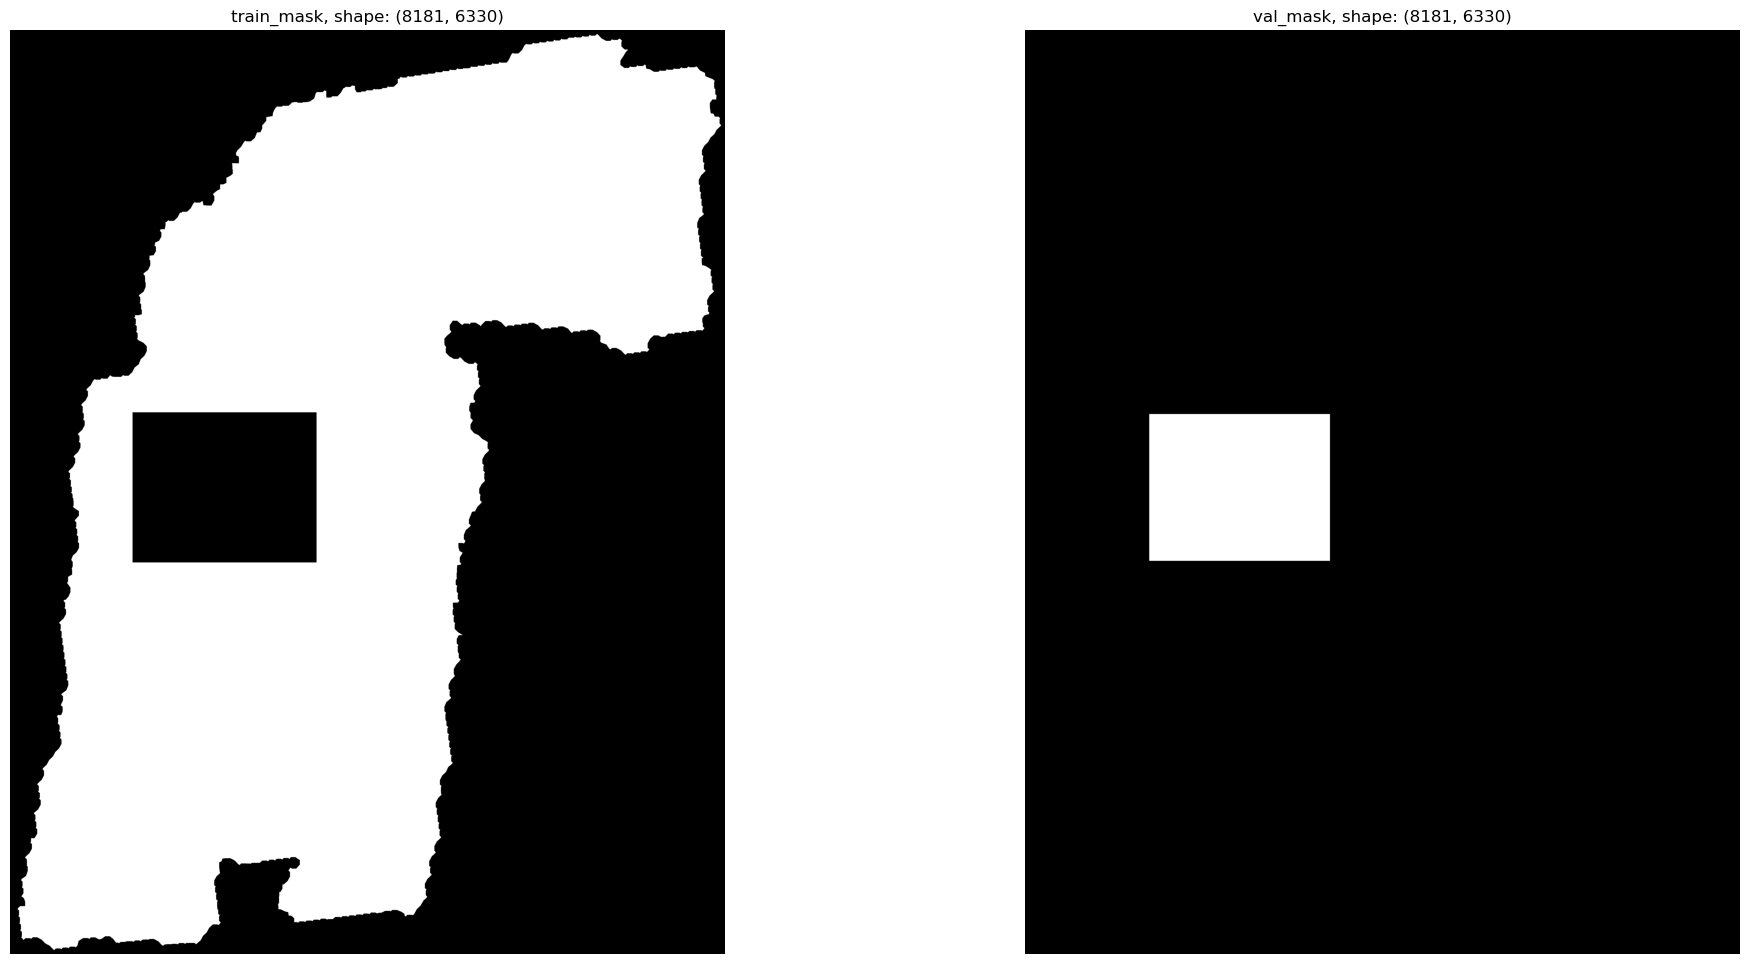

In [12]:
train_mask, val_mask = get_train_val_masks(mask, rect, config["subvolume_size"])  # Need more values to unpack warning
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
axs.flatten()
show_array(train_mask, "train_mask", axs[0])
show_array(val_mask, "val_mask", axs[1])

In [21]:
# What is this? The average of each class in their respective zones? If so needs to be better balanced
# IS the train for the whole image or only for inside the mask
print(f"ink class in train mask: {np.mean(inklabels[train_mask == 1]):.4f}")
print(f"ink class in val mask: {np.mean(inklabels[val_mask == 1]):.4f}") 

ink class in train mask: 0.1806
ink class in val mask: 0.2967


## Dataset and DataLoaders

In [22]:
train_pixels = list(zip(*np.where(train_mask == 1)))
val_pixels = list(zip(*np.where(val_mask == 1)))
del train_mask, val_mask
gc.collect();

In [36]:
class SubvolumeDataset(Dataset):
    def __init__(self, volume: np.ndarray, inklabels: np.ndarray, pixels: List[Tuple], subvolume_size: int):
        self.volume = volume
        self.inklabels = inklabels
        # pixels in train or validation mask
        self.pixels = pixels
        self.subvolume_size = subvolume_size  # is this 30? Then same as buffer in tutorial

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        y, x = self.pixels[idx]
        # no .view like tutorial
        subvolume = self.volume[:,
                                y - self.subvolume_size : y + self.subvolume_size,
                                x - self.subvolume_size : x + self.subvolume_size]
        # 3d notebook had  subvolume = subvolume[np.newaxis, ...] here. Debug with ctrl U
        subvolume = torch.from_numpy(subvolume).to(torch.float32)
        inklabel = torch.tensor(self.inklabels[y, x], dtype=torch.float32)
        return subvolume, inklabel


def create_data_loader(batch_size: int, pixels: List[Tuple], dataset_kwargs: dict, shuffle: bool) -> DataLoader:
    dataset = SubvolumeDataset(pixels=pixels, **dataset_kwargs)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader


# From 3D notebook. has both train and valid pixels input and returns a tuple of dataloaders.
def create_data_loaders(batch_size: int, train_pixels: List[Tuple], val_pixels: List[Tuple], dataset_kwargs: dict) -> Tuple[DataLoader]:
    train_ds = SubvolumeDataset(pixels=train_pixels, **dataset_kwargs)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

    val_ds = SubvolumeDataset(pixels=val_pixels, **dataset_kwargs)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
    return train_loader, val_loader


# Creates a video to show the subvolume? Cool if true.
def show_single_subvolume_batch(subvolume: Tensor, inklabel: Tensor) -> None:
    subvolume = torch.squeeze(subvolume)
    plt.rcParams["figure.dpi"] = 350
    plt.style.use("dark_background")
    num_slices = subvolume.shape[0]
    fig = plt.figure()
    camera = Camera(fig)
    for idx in range(num_slices):
        plt.imshow(subvolume[idx, :, :], cmap="gray")
        plt.text(x=0, y=-1, s=f"slice {idx+1}/{num_slices}", horizontalalignment="center")
        plt.text(x=-6, y=-3, s=f"ink label: {inklabel.item()}")
        plt.axis("off")
        camera.snap()
    animation = camera.animate()
    plt.close(fig)
    fix_video_adjust = "<style> video {margin: 0px; padding: 0px; width:100%; height:auto;} </style>"
    display(HTML(fix_video_adjust + animation.to_html5_video()))
    animation.save('test.mp4')
    del animation
    gc.collect()

## Visualize batches

In [39]:
# Finds batches where there is always ink in it.
def find_batches_both_classes(data_loader: DataLoader) -> Tuple[Tuple]:
    batch_inklabel_0 = None
    batch_inklabel_1 = None
    for subvolume, inklabel in data_loader:  # 3D used train_loader_check instead of data_loader. bug in their code?
        if inklabel.item() == 0 and batch_inklabel_0 is None:
            batch_inklabel_0 = subvolume, inklabel
        if inklabel.item() == 1 and batch_inklabel_1 is None:
            batch_inklabel_1 = subvolume, inklabel
        if batch_inklabel_0 is not None and batch_inklabel_1 is not None:
            break
    return batch_inklabel_0, batch_inklabel_1

In [40]:
dataset_kwargs = {"volume": volume, "inklabels": inklabels, "subvolume_size": config["subvolume_size"]}

if not DEBUG:
    #     train_loader_check, val_loader_check = create_data_loaders(1, train_pixels, val_pixels, dataset_kwargs)  3D version
    train_loader_check = create_data_loader(1, train_pixels, dataset_kwargs, shuffle=True)
    batch_inklabel_0, batch_inklabel_1 = find_batches_both_classes(train_loader_check)
    show_single_subvolume_batch(batch_inklabel_0[0], batch_inklabel_0[1])
    del train_loader_check, batch_inklabel_0  # val_loader_check, 3D version
    gc.collect();

In [41]:
if not DEBUG:
    show_single_subvolume_batch(batch_inklabel_1[0], batch_inklabel_1[1])
    del batch_inklabel_1
    gc.collect();

## Model

In [42]:
class InkClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.backbone = timm.create_model(config["model_name"], pretrained=True, in_chans=10, num_classes=0)  # only 10 in channels?
        self.backbone_dim = self.backbone(torch.rand(1, config["z_dim"], 2 * config["subvolume_size"], 2 * config["subvolume_size"])).shape[-1]
        self.classifier = nn.Linear(in_features=self.backbone_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.backbone(x)  # Pretrained efficientnet_b0 model
        logits = self.classifier(x)  # Classifies as ink/no_ink
        out = self.sigmoid(logits)  # Sigmoid for some reason
        return out.flatten()  # Flatten that bitch?

In [43]:
def dice_coef_torch(preds: Tensor, targets: Tensor, beta=0.5, smooth=1e-5) -> float:
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    # comment out if your model contains a sigmoid or equivalent activation layer. Ie You have already sigmoid(ed)
    #preds = torch.sigmoid(preds)

    # flatten label and prediction tensors
    preds = preds.view(-1).float()
    targets = targets.view(-1).float()

    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)
    return dice

# Like val but also has train_steps, optimizer, logger params
def train_fn(train_steps: int, train_loader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer, logger):
    model.train()  # sets model into train mode.

    for i, (x, y) in enumerate(train_loader):  # x, y are (volume np.ndarray, inklabels: np.ndarray)
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        if DEBUG and (i > 5):  # Stop iterating if debug and beyond 5 "batches". Rename i to batch_id or something
            break
        if i > train_steps:  # Only do so many train steps.
            break

        optimizer.zero_grad()  # Resets the gradients
        yhat = model(x)  # Run the model predictions
        loss = loss_fn(yhat, y)  # Calculate loss
        loss.backward()
        optimizer.step()  # update dem weights
        logger.log({"train_loss": loss.item(), "train_dice": dice_coef_torch(yhat, y)})
        try:  # .detach() Returns a new Tensor, detached from the current graph.
            train_auc = roc_auc_score(y.detach().cpu().numpy(), yhat.detach().cpu().numpy())
            logger.log({"train_auc": train_auc})
        except ValueError:
            pass


@torch.no_grad()
def val_fn(val_loader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> dict:
    run_loss = AverageCalc()
    model.eval()  # Sets the model into evaluation mode
    y_val = []
    yhat_val = []

    for i, (x, y) in enumerate(val_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch_size = x.shape[0]

        if DEBUG and (i > 5):
            break

        yhat = model(x)  # .squeeze(1) 3D
        loss = loss_fn(yhat, y)
        run_loss.update(loss.item(), x.shape[0])

        y_val.append(y.cpu())
        yhat_val.append(yhat.cpu())

    y_val = torch.cat(y_val)  # Concatenates the given sequence of seq tensors in the given dimension
    yhat_val = torch.cat(yhat_val)
    df_val = pd.DataFrame({"y_val": y_val, "yhat_val": yhat_val})

    try:
        val_auc = roc_auc_score(y_val.numpy(), yhat_val.numpy())
    except ValueError:
        val_auc = np.nan

    return {"val_loss": run_loss.avg, "val_dice": dice_coef_torch(yhat_val, y_val),
            "val_auc": val_auc, "df_val": df_val}


@torch.no_grad()
def generate_ink_pred(val_loader: DataLoader, model: nn.Module, val_pixels: List[Tuple[int, int]]) -> Tensor:
    model.eval()  # Sets the model into evaluation mode
    output = torch.zeros(IMAGE_SHAPE, dtype=torch.float32)
    for i, (x, y) in enumerate(val_loader):  # Todo add tqdm?
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        batch_size = x.shape[0]

        yhat = model(x)
        for j, pred in enumerate(yhat):   # Todo add tqdm?
            output[val_pixels[i * batch_size + j]] = pred
    return output

# ACTUALLY Train the model

In [44]:
model = InkClassifier(config).to(DEVICE)
print(f'Model is: {model}')
loss_fn = nn.BCELoss()
logger = DummyLogger() if DEBUG else create_logger(config)  # Todo remove this and all debug stuff?

# train_loader, val_loader = create_data_loaders(config["batch_size"], train_pixels, val_pixels, dataset_kwargs) 3D
train_loader = create_data_loader(config["batch_size"], train_pixels, dataset_kwargs, shuffle=True)
val_loader = create_data_loader(config["batch_size"], val_pixels, dataset_kwargs, shuffle=False)
optimizer = Adam(model.parameters())
best_val_dice = 0

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to C:\Users\gamer/.cache\torch\hub\checkpoints\efficientnet_b0_ra-3dd342df.pth


Model is: InkClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, 

In [45]:
print(f"Train the model for {config['train_rounds']} rounds")
for rnd in range(config["train_rounds"]):  # Did they mean epoch? TODO add tqdm?
    train_fn(config["train_steps"], train_loader, model, loss_fn, optimizer, logger)
    val_dict = val_fn(val_loader, model, loss_fn)  # Dict of {"val_loss", "val_dice", "val_auc", "df_val"}

    logger.log({"val_loss": val_dict["val_loss"], "val_dice": val_dict["val_dice"], "val_auc": val_dict["val_auc"]})

    if val_dict["val_dice"] > best_val_dice:
        best_val_dice = val_dict["val_dice"]
        torch.save(model.state_dict(), f"{EXPERIMENT_NAME}.pt")
        print(f"Model saved at round {rnd} with val_dice {val_dict['val_dice']:.4f}.")
        if LOG_TABLE:
            logger.log({"table": wandb.Table(dataframe=val_dict["df_val"])})
logger.finish()

Train the model for 3 rounds
Model saved at round 0 with val_dice 0.5798.


Model saved at round 1 with val_dice 0.5906.


train_auc,▂▃▁▅▆█▃▇▅▆▆▅▅▅█▇▇▇█▆▇▆███▇█▇███▆█▇▆████▆
train_dice,▃▂▂▃▄▁▄▄▃▃▄▄▄▅▆▆▇▅▆▂▇▃▇▄▆▆█▅▂▆▇▅▅█▆▇█▅▆▇
train_loss,█▆▃▄▄▃▅▄▆▇▃▂▄▂▁▂▂▃▃▃▂▂▁▂▁▆▂▃▃▁▄▂▃▂▁▂▂▃▂▁
val_auc,█▆▁
val_dice,▆█▁
val_loss,▁▃█
train_auc,0.97714
train_dice,0.69716
train_loss,0.19453
val_auc,0.77688
val_dice,0.5511


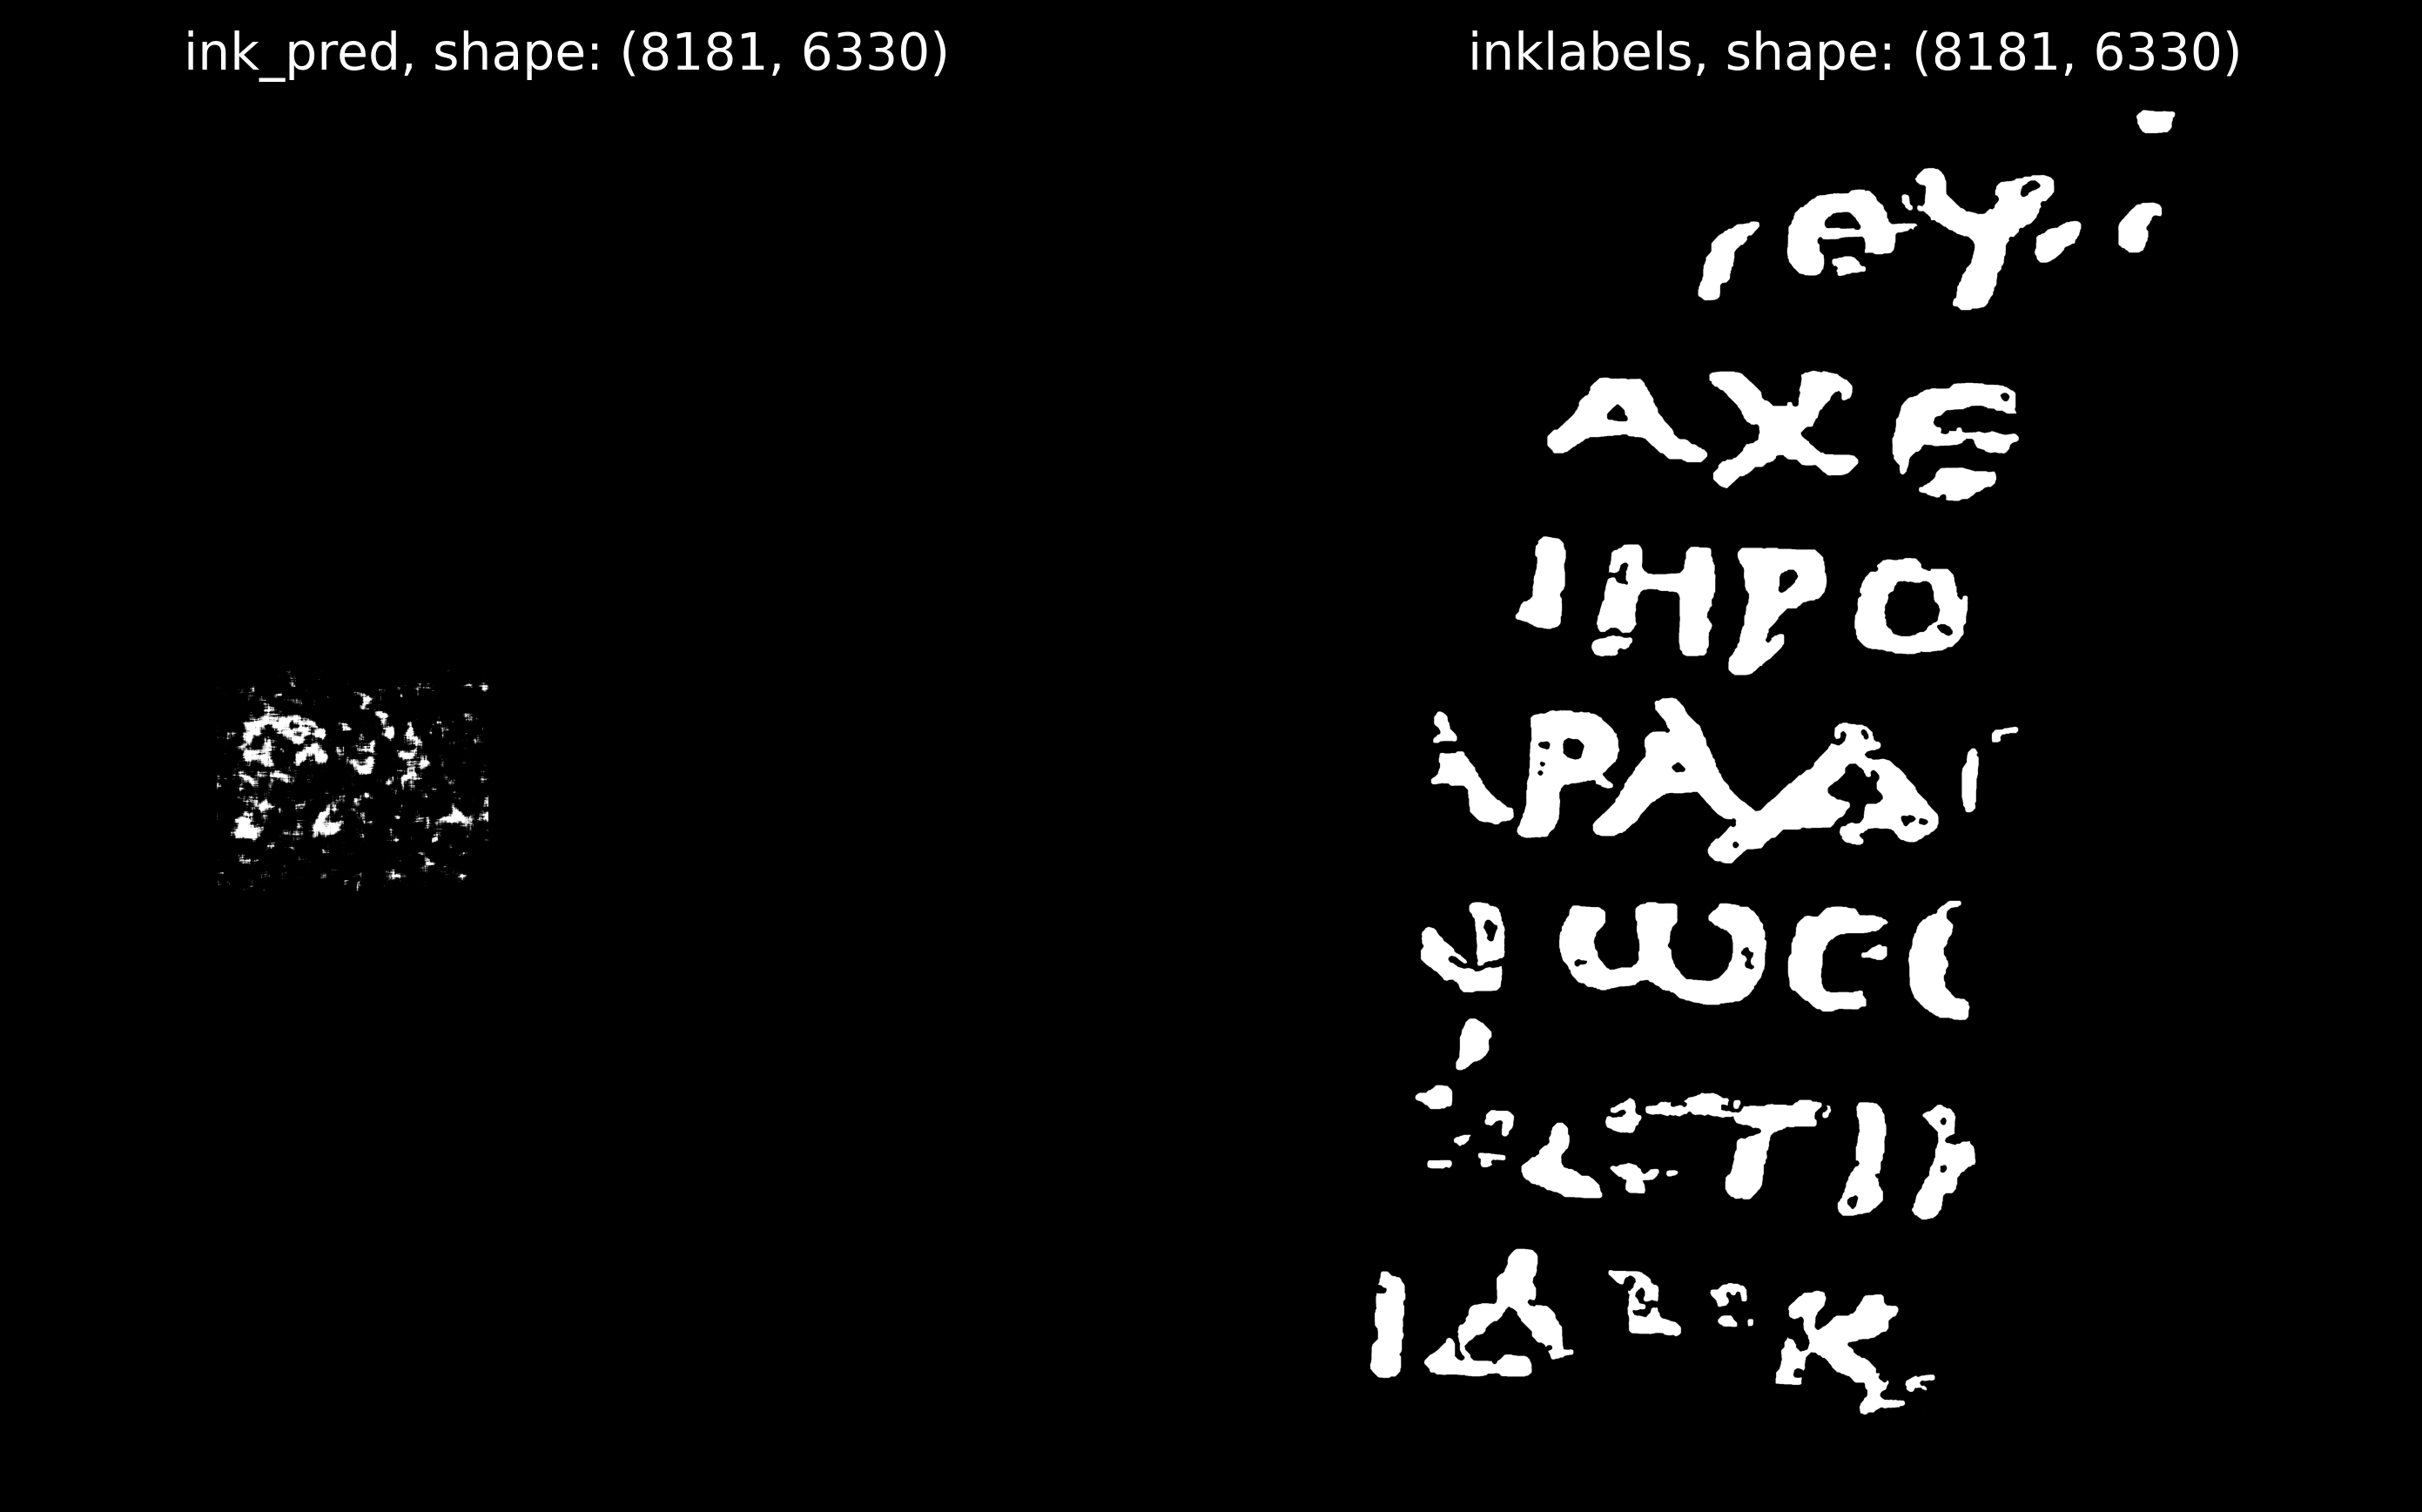

In [46]:
ink_pred = generate_ink_pred(val_loader, model, val_pixels)
if not DEBUG:
    del train_pixels, val_pixels
    gc.collect()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs.flatten()
show_array(ink_pred.gt(config["threshold"]).cpu().numpy(), "ink_pred", axs[0])
show_array(inklabels, "inklabels", axs[1])